# ASL Alphabet 🔣

Image data set for alphabets in the American Sign Language 

The training data set contains 87,000 images which are 200x200 pixels. 

There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING.

These 3 classes are very helpful in real-time applications, and classification.

The test data set contains a mere 29 images, to encourage the use of real-world test images.

**Papers**: [American Sign Language Alphabet Recognition using
Deep Learning](https://arxiv.org/pdf/1905.05487.pdf)

**Squeezenet Papers**: [Squeezenet](https://arxiv.org/pdf/1602.07360.pdf)

## Importing packages 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib 
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D, AvgPool2D, Dropout, Activation
from tensorflow.keras import  Sequential
from tensorflow.keras.optimizers import  Adam

## Download data from kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!ls ~/.kaggle 

kaggle.json


In [4]:
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d grassknoted/asl-alphabet

 98% 1.01G/1.03G [00:25<00:00, 32.0MB/s]
100% 1.03G/1.03G [00:25<00:00, 43.8MB/s]


In [ ]:
!unzip "/content/asl-alphabet.zip"

## Visualize data

In [6]:
import os 

for dirpath, dirnames, filenames in os.walk("/content/asl_alphabet_train/asl_alphabet_train"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 29 directories and 0 images in /content/asl_alphabet_train/asl_alphabet_train
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/W
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/R
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/Y
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/Q
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/nothing
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/B
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/space
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/C
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl_alphabet_train/X
There are 0 directories and 3000 images in /content/asl_alphabet_train/asl

In [7]:
data_dir = pathlib.Path("asl_alphabet_train/asl_alphabet_train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'del', 'nothing', 'space'], dtype='<U7')

In [8]:
def view_random_image(target_dir, target_class):

    # Set up target directory
    target_file = target_dir + target_class

    #Get a random image class 
    random_image = random.sample(os.listdir(target_file), 1)

    # Read image and visualize image
    img = mpimg.imread(target_file + '/' + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis(False)

    print(f"Image shape: {img.shape}") # show the shape of the image
    
    return img

Image shape: (200, 200, 3)


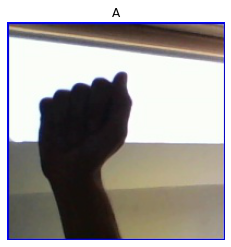

In [9]:
view_random_image('/content/asl_alphabet_train/asl_alphabet_train/', 'A');

Image shape: (200, 200, 3)


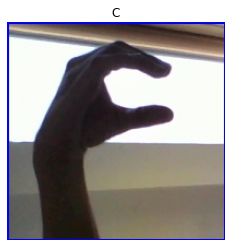

In [10]:
view_random_image('/content/asl_alphabet_train/asl_alphabet_train/', 'C');

Image shape: (200, 200, 3)


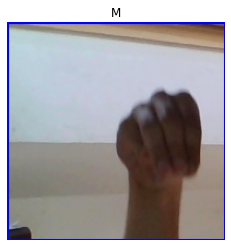

In [11]:
view_random_image('/content/asl_alphabet_train/asl_alphabet_train/', 'M');

Image shape: (200, 200, 3)


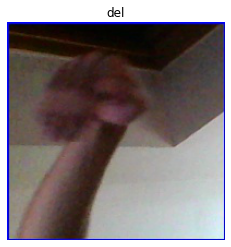

In [12]:
view_random_image('/content/asl_alphabet_train/asl_alphabet_train/', 'del');

In [13]:
from numpy.lib.utils import source
import shutil

rootdir = '/content/asl_alphabet_train/asl_alphabet_train'

for i in class_names:
    os.makedirs(rootdir + '/train/' + i)
    os.makedirs(rootdir + '/test/' + i)
    source = rootdir +'/' + i

    allFileNames = os.listdir(source)
    np.random.shuffle(allFileNames)

    train_size = 0.8
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames) * train_size)])

    train_FileNames = [source + '/' + name for name in train_FileNames.tolist()]
    test_FileNames = [source + '/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
      shutil.copy(name, rootdir + '/train/' + i)

    for name in test_FileNames:
      shutil.copy(name, rootdir + '/test/' + i)

## Processing image

In [14]:
train_dir = '/content/asl_alphabet_train/asl_alphabet_train/train'
test_dir = '/content/asl_alphabet_train/asl_alphabet_train/test'

train_datagen = ImageDataGenerator(rescale= 1./255)
test_datagen = ImageDataGenerator(rescale= 1./255)

# Turn it into the batches 
train_data = train_datagen.flow_from_directory(train_dir, 
                                              target_size= (244, 244),
                                              batch_size= 64,
                                              seed = 42)

test_data = test_datagen.flow_from_directory(test_dir, 
                                            target_size= (244, 244),
                                            batch_size= 64,
                                            seed = 42)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


## Create the model

In [15]:
def fire_module(x, s1, e1, e3):

    s1x = Conv2D(s1, kernel_size= 1, padding = 'same')(x)
    s1x = tf.keras.layers.ReLU()(s1x)

    e1x = Conv2D(e1, kernel_size= 1, padding= 'same')(s1x)
    e3x = Conv2D(e3, kernel_size= 3, padding= 'same')(s1x)

    x = tf.keras.layers.concatenate([e1x, e3x])

    x = tf.keras.layers.ReLU()(x)

    return x 

In [16]:
def SqueezeNet(input_shape, nclasses):

    input = Input(input_shape)
    x = Conv2D(96,kernel_size=(7,7),strides=(2,2),padding='same')(input)
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 16, e1 = 64, e3 = 64) #2
    x = fire_module(x, s1 = 16, e1 = 64, e3 = 64) #3
    x = fire_module(x, s1 = 32, e1 = 128, e3 = 128) #4
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 32, e1 = 128, e3 = 128) #5
    x = fire_module(x, s1 = 48, e1 = 192, e3 = 192) #6
    x = fire_module(x, s1 = 48, e1 = 192, e3 = 192) #7
    x = fire_module(x, s1 = 64, e1 = 256, e3 = 256) #8
    x = MaxPool2D(pool_size=(3,3), strides = (2,2))(x)
    x = fire_module(x, s1 = 64, e1 = 256, e3 = 256) #9
    x = Dropout(0.5)(x)
    x = Conv2D(nclasses,kernel_size = 1)(x)
    x = GlobalAveragePooling2D()(x)

    output = Activation('softmax', name='loss')(x)
    model = tf.keras.Model(input, output)
    
    return model

In [17]:
model = SqueezeNet(input_shape = (244, 244, 3), nclasses = 29)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 122, 122, 96  14208       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 60, 60, 96)   0           ['conv2d[0][0]']                 
                                                                                              

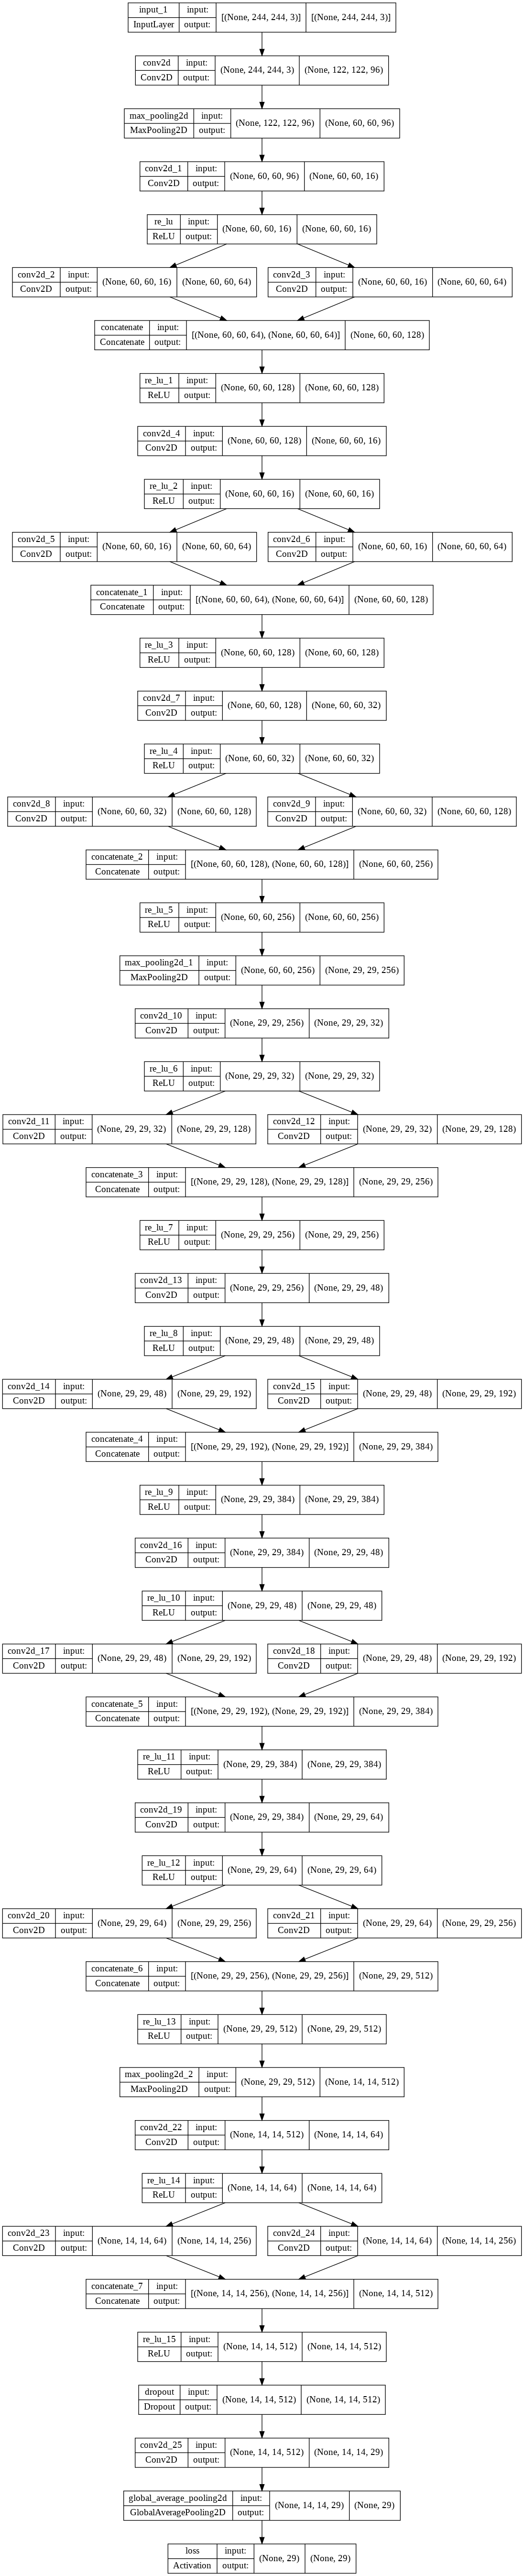

In [19]:
tf.keras.utils.plot_model(model, show_shapes= True)

In [20]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
    metrics = ['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [22]:
history = model.fit(train_data, epochs = 10,
                    validation_data = test_data,
                    callbacks = early_stop)

Epoch 1/10
1088/1088 [==============================] - 539s 480ms/step - loss: 3.2527 - accuracy: 0.0686 - val_loss: 2.8925 - val_accuracy: 0.1298
Epoch 2/10
1088/1088 [==============================] - 519s 477ms/step - loss: 2.4747 - accuracy: 0.2575 - val_loss: 1.7827 - val_accuracy: 0.4664
Epoch 3/10
1088/1088 [==============================] - 521s 478ms/step - loss: 1.3965 - accuracy: 0.5597 - val_loss: 0.8571 - val_accuracy: 0.7423
Epoch 4/10
1088/1088 [==============================] - 520s 478ms/step - loss: 0.6522 - accuracy: 0.7917 - val_loss: 0.3356 - val_accuracy: 0.8862
Epoch 5/10
1088/1088 [==============================] - 520s 478ms/step - loss: 0.3434 - accuracy: 0.8883 - val_loss: 0.2427 - val_accuracy: 0.9171
Epoch 6/10
1088/1088 [==============================] - 521s 478ms/step - loss: 0.1970 - accuracy: 0.9359 - val_loss: 0.1081 - val_accuracy: 0.9668
Epoch 7/10
1088/1088 [==============================] - 520s 478ms/step - loss: 0.1281 - accuracy: 0.9600 - val_

## Evaluate model 

In [24]:
model.evaluate(test_data)

272/272 [==============================] - 45s 165ms/step - loss: 0.0122 - accuracy: 0.9968


[0.012205090373754501, 0.9968391060829163]

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

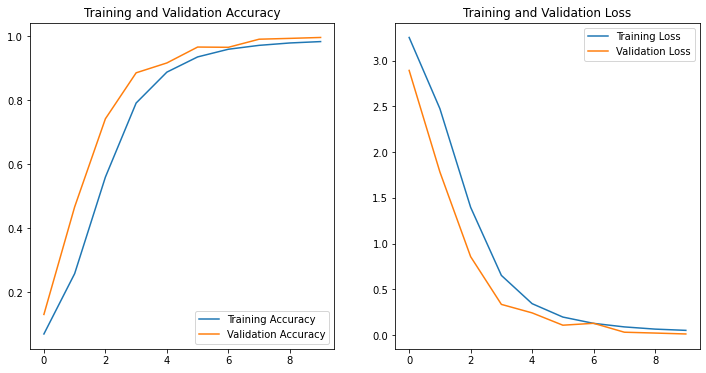

In [27]:
epochs_range = range(10)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()